# imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/crypto-classifier/data'
!ls

Mounted at /content/drive
/content/drive/MyDrive/crypto-classifier/data
 120_influ_total.json			    lunarcrush_influencers
 2000_crypto_sample.csv			    model.pt
 20coin_MC_lunarCrush_30days.csv	    models
 20coin_MC_lunarCrush_60days.csv	    multy_platform
 all_tweets.v2.csv			    new_sell.csv
 cardiffnlp				    new_tag
'classification_reports (1).gsheet'	    old
 classification_reports.csv		    parameter_tuning.csv
 classification_reports.gsheet		    parameter_tuning.gsheet
 cleaned_dataset.csv			    predict_crypto_keyword_2000.csv
 cleaned_dataset.pickle			    predict_crypto_keyword_2000.xlsx
 cleaned_dataset_sell.pickle		    reddit_data.csv
 cleanTweet_800.csv			    relevant_crypto_TfidfVectorizer
 coinList_100.csv			    Relevant_model
 coin_name.csv				    result_data.zip
 crypto_augmented_features_relevant	    sample_instagram_3000.v1.csv
 crypto_augmented_features_signal	    sample_reddit_3000.v1.csv
 crypto_keyword_total.csv		    stop_words_english.txt
 crypto_signal_model			  

In [2]:
import re
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from string import digits

import math
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from nltk import bigrams
warnings.filterwarnings('ignore')

# read data

In [3]:
with open ('tag3/cleanTweet1000.pickle', 'rb') as fp:
    dataset = pickle.load(fp)

In [4]:
dataset.shape

(1927, 70)

In [5]:
# dataset = dataset.sample(n=800).reset_index(drop=True)
print('number of total tweets is ',len(dataset))

dataset['Ambiguous'] = dataset['Ambiguous'].fillna(0)
print(Counter(dataset['Ambiguous']))
for i in range(len(dataset)):
  if dataset['Ambiguous'][i] != 0:
    dataset['signal'][i]='no signal'
    dataset['polarity'][i]='neutral'

keys=['unicode_text_clean', 'unicode_text_concat', 'clean_text', 'concat_fields', 'hashtags', 'emojies', 'tokenied', 'bigrams',
'coins','dolar', 'mentions', 'links',
'num_hashtags', 'num_mentions',
'no_media', 'animated_gif', 'photo', 'video',
'Newyork_stockmarket_date', 'Newyork_stockmarket',
'day_week','day_month','month',
'signal']

data=dataset[keys]

data['signal']=data['signal'].apply(lambda x:'not buy' if x in ['sell','no signal','hold'] else x)
print('signal categories: ',Counter(data['signal']))
# data['polarity']=data['polarity'].apply(lambda x:'not positive' if x in ['negative','neutral'] else x)
# print('polarity categories: ',Counter(data['polarity']))


X = data['unicode_text_concat'].to_list()
y = data['signal'].to_list()

labels = {'not buy':0, 'buy':1}
for i in range(len(y)):
  data['signal'][i]=labels[data['signal'][i]]

# data = data[['unicode_text_concat','signal']].rename(columns={'unicode_text_concat':'tweet', 'signal':'labl'})
data

number of total tweets is  1927
Counter({0: 1871, '1': 56})
signal categories:  Counter({'buy': 1077, 'not buy': 850})


,unicode_text_clean,unicode_text_concat,clean_text,concat_fields,hashtags,emojies,tokenied,bigrams,coins,dolar,...,no_media,animated_gif,photo,video,Newyork_stockmarket_date,Newyork_stockmarket,day_week,day_month,month,signal
0,core philosophy revolve build ship product fin...,Our core philosophy revolves around building a...,core philosophy revolve build ship product fin...,Our core philosophy revolves around building a...,"[#elrond, #elrondmainnet]",[👇],"[core, philosophy, revolve, build, ship, produ...","[core philosophy, philosophy revolve, revolve ...",[elrond],{},...,1,0,0,0,False,0,-1,-1,-1,1
1,today's a_coin_name upsurge coincide bitfinex ...,Today's a_coin_name upsurge coincided with the...,today's bitcoin upsurge coincide bitfinex main...,Today's bitcoin upsurge coincided with the Bit...,[],[],"[today's, bitcoin, upsurge, coincide, bitfinex...","[today's bitcoin, bitcoin upsurge, upsurge coi...",[bitcoin],{},...,1,0,0,0,False,0,-1,-1,-1,1
2,a_coin_name world wbd a_number - colombia a_co...,*Bitcoin Around the World* WBD a_number - Colo...,bitcoin world wbd193 - colombia bitcoin regula...,*Bitcoin Around the World*\n\nWBD193 - Colombi...,[],[],"[bitcoin, world, wbd193, -, colombia, bitcoin,...","[bitcoin world, world wbd193, wbd193 -, - colo...",[bitcoin],{},...,1,0,0,0,True,0,1,11,2,1
3,high leverage crypto market crash a_coin_name ...,High leverage in the crypto market helped cras...,high leverage crypto market crash #bitcoin $36...,High leverage in the crypto market helped cras...,[#bitcoin],[],"[high, leverage, crypto, market, crash, #bitco...","[high leverage, leverage crypto, crypto market...",[bitcoin],{3600},...,1,0,0,0,True,0,1,17,3,0
4,feed print unlimited money pump market = good ...,Fed printing unlimited money to pump markets =...,feed print unlimited money pump market = good ...,Fed printing unlimited money to pump markets =...,[],[],"[feed, print, unlimited, money, pump, market, ...","[feed print, print unlimited, unlimited money,...",[bitcoin],{},...,1,0,0,0,True,0,1,24,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922,simon dixon mauricio bartlolomeo - swan signal...,Simon Dixon and Mauricio Di Bartlolomeo - Swan...,simon dixon mauricio bartlolomeo - swan signal...,Simon Dixon and Mauricio Di Bartlolomeo - Swan...,[],[],"[simon, dixon, mauricio, bartlolomeo, -, swan,...","[simon dixon, dixon mauricio, mauricio bartlol...",[bitcoin],{},...,1,0,0,0,True,1,3,3,3,0
1923,ukraine ukrainian government raise $ a_number ...,🇺🇦 The Ukrainian government has raised over $ ...,ukraine ukrainian government raise $48 million...,🇺🇦 The Ukrainian government has raised over $4...,"[#bitcoin, #binance, #binance]",[🤨],"[ukraine, ukrainian, government, raise, $48, m...","[ukraine ukrainian, ukrainian government, gove...",[bitcoin],"{48, 10}",...,1,0,0,0,True,0,4,4,3,0
1924,number address hold a_number a_coin_name a_num...,JUST IN: The number of addresses holding at le...,number address hold 1000 #bitcoin 2261 highest...,JUST IN: The number of addresses holding at le...,[#bitcoin],[],"[number, address, hold, 1000, #bitcoin, 2261, ...","[number address, address hold, hold 1000, 1000...",[bitcoin],{},...,1,0,0,0,False,0,6,6,3,1
1925,condition 'ripe' a_coin_name adoption amid geo...,Conditions ‘ripe’ for Bitcoin adoption amid ge...,condition 'ripe' bitcoin adoption amid geopoli...,Conditions ‘ripe’ for Bitcoin adoption amid ge...,[],[],"[condition, 'ripe', bitcoin, adoption, amid, g...","[condition 'ripe', 'ripe' bitcoin, bitcoin ado...",[bitcoin],{},...,0,0,1,0,False,0,6,6,3,1


In [6]:
print('categories: ',Counter(data['signal']))

categories:  Counter({1: 1077, 0: 850})


In [7]:
!pip install python-bidi
!pip install arabic_reshaper

from bidi.algorithm import get_display
import arabic_reshaper as ar

In [8]:
disppersian = lambda text : get_display(ar.reshape(text))

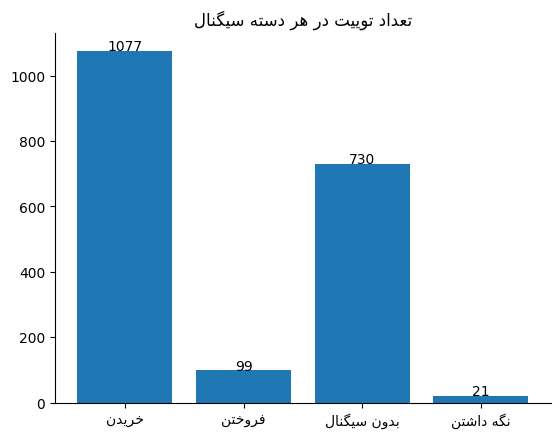

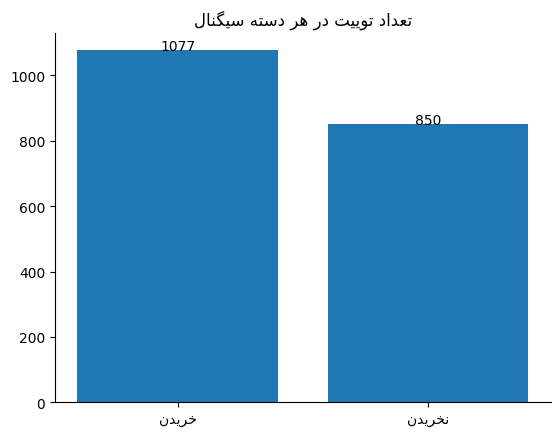

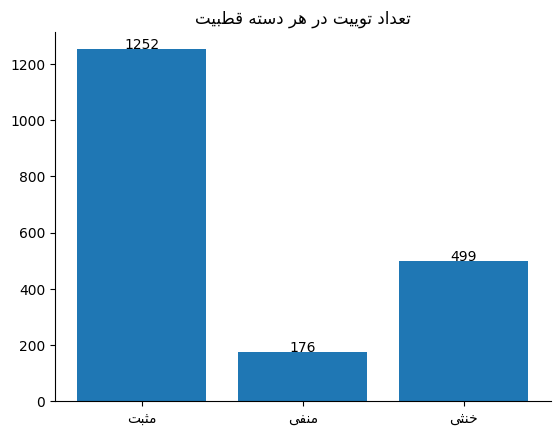

In [9]:
def plot_with_borders(x, y,plot_name,file_name):
    fig, ax = plt.subplots()
    ax.bar(x, y)

    # Set the left and bottom spines to be visible
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Set the top and right spines to be invisible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Display the height of bars on the plot
    for i, v in enumerate(y):
        ax.text(i, v + 0.5, str(v), ha='center')

    # Set the title of the figure
    plt.title(disppersian(plot_name))

    # Save the plot with 1080 resolution
    plt.savefig(f'Figures/{file_name}.png', dpi=1080)



    plt.show()


dictionary_of_signal_names = {'hold':'نگه داشتن',
                        'no signal':'بدون سیگنال',
                        'sell':'فروختن',
                        'buy':'خریدن',
                        }

dictionary_of_polarity_names = {'neutral':'خنثی',
                        'negative':'منفی',
                        'positive':'مثبت',
                        }

dictionary_of_signal_bnb = {0:'نخریدن',
                        1:'خریدن'
                        }



x=list(Counter(dataset['signal'].apply(lambda x:disppersian(dictionary_of_signal_names[x]))).keys())
y=list(Counter(dataset['signal'].apply(lambda x:disppersian(dictionary_of_signal_names[x]))).values())
plot_with_borders(x, y,'تعداد توییت در هر دسته سیگنال','signal_count')


x=list(Counter(data['signal'].apply(lambda x:disppersian(dictionary_of_signal_bnb[x]))).keys())
y=list(Counter(data['signal'].apply(lambda x:disppersian(dictionary_of_signal_bnb[x]))).values())
plot_with_borders(x, y,'تعداد توییت در هر دسته سیگنال','signal2_count')


x=list(Counter(dataset['polarity'].apply(lambda x:disppersian(dictionary_of_polarity_names[x]))).keys())
y=list(Counter(dataset['polarity'].apply(lambda x:disppersian(dictionary_of_polarity_names[x]))).values())
plot_with_borders(x, y,'تعداد توییت در هر دسته قطبیت','polarity_count')



In [10]:
data=data[keys].rename(columns={'signal':'tag'})

## keep only domains of links

In [11]:
from urllib.parse import urlparse
data['links']=data['links'].apply(lambda x:[urlparse(i).netloc.replace('www.','') for i in x])

## change label

In [13]:
data[['clean_text','tag']].head(10)

,clean_text,tag
0,core philosophy revolve build ship product fin...,1
1,today's bitcoin upsurge coincide bitfinex main...,1
2,bitcoin world wbd193 - colombia bitcoin regula...,1
3,high leverage crypto market crash #bitcoin $36...,0
4,feed print unlimited money pump market = good ...,1
5,data tokenanalyst suggest crypto trader prepar...,1
6,blockchain save @betprotocol transaction data ...,1
7,week $erd backhand_index_pointing_down_light_s...,0
8,smiling_face_with_sunglasses money_bag 2017 cr...,1
9,@ameensol @aridavidpaul @nickszabo4 szabo trig...,0


# coin vector feature

In [14]:
bk=pd.read_csv('Top_100_coinMarketCap.csv')
coin_name=bk['cname']

coindf=pd.DataFrame(columns=coin_name, index=list(range(len(data))))
coindf
for i,clist in enumerate(data['coins']):
  for c in clist:
    coindf.iloc[i][c]=1
coindf=coindf.fillna(0)
coindf

cname,1inch network,aave,algorand,amp,arweave,avalanche,axie infinity,basic attention token,binance usd,bitcoin,...,uniswap,unus sed leo,usd coin,vechain,waves,wrapped bitcoin,xdc network,xrp,yearn.finance,zcash
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1923,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1924,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1925,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#split data

In [15]:
train_index, test_index ,y_train, y_test = train_test_split(data.index, data['tag'], test_size=0.15, random_state=101)

print(f'train: {len(y_train)}   ',Counter(y_train))
print(f'test:  {len(y_test)}   ',Counter(y_test))

train_df=data.iloc[train_index]
train_df['tag']=train_df['tag'].astype('int')

train: 1637    Counter({1: 918, 0: 719})
test:  290    Counter({1: 159, 0: 131})


# features extraction

### keywords as features

In [16]:
train_df=data.iloc[train_index]
train_df['tag']=train_df['tag'].astype('int')

In [17]:
def new_f_func(col,y,threshold, symmetric_difference=1):
  idf=[{},{}]

  # col=col.apply(lambda x:x.replace('@user',''))
  wdf=col.apply(lambda x:list(set(x))) #word in doc frequency
  for i,s in enumerate(wdf):
      y_ = y[i]
      for w in s:
          if w in idf[y_]:
              idf[y_][w]+=1
          else:
              idf[y_][w]=1

  sorted_idf=[[],[]]
  for i,idf_i in enumerate(idf):
      idf_i = {key:val for key, val in idf_i.items() if val > threshold}
      sorted_idf[i]=sorted(idf_i,key=lambda x:-idf_i[x])
  new_f=[]
  if symmetric_difference: # A delta B = words that is only in one of classes
    for f in sorted_idf:
      new_f.extend(f)
    hist=Counter(new_f)
    return list({key for key, val in hist.items() if val == 1})
  else:
    for f in sorted_idf:
      new_f.extend(f[:len(f)//2]) # the upper half after sorting
    return list(set(new_f))



def eliminate_numbers(tokens):
    result = []
    for token in tokens:
        if not token.isdigit():
            result.append(token)
    return result



In [18]:

augmented_features_words0=new_f_func(train_df['tokenied'].apply(lambda x: eliminate_numbers(x)),train_df['tag'].values,5)
augmented_features_words1=list(set(new_f_func(train_df['hashtags'],train_df['tag'].values,2,0)+new_f_func(train_df['hashtags'],train_df['tag'].values,2)))
augmented_features_words2=new_f_func(train_df['bigrams'],train_df['tag'].values,3)
augmented_features_words3=list(set(new_f_func(train_df['links'],train_df['tag'].values,2,0)+new_f_func(train_df['links'],train_df['tag'].values,1)))
augmented_features_words4=new_f_func(train_df['mentions'],train_df['tag'].values,3)
augmented_features_words5=list(set(new_f_func(train_df['emojies'],train_df['tag'].values,3,0)+new_f_func(train_df['emojies'],train_df['tag'].values,8)))
features_words=({'tokens':set(augmented_features_words0),'bigrams':set(augmented_features_words2),'hashtags':set(augmented_features_words1),'emojies':augmented_features_words5})

# features_words=set([k.replace('#','') for k in (features_words)])
print(features_words)
augmented_features={}
for i in features_words.keys():
  augmented_features[i]={k : v for v, k in enumerate(features_words[i])}

augmented_features_links={k : v for v, k in enumerate(set(augmented_features_words3))}
augmented_features_mentions={k : v for v, k in enumerate(set(augmented_features_words4))}

{'tokens': {'stack', 'trophy', 'chart_increasing', '$luna', '@pancakeswap', 'connect', 'currency', 'issue', 'competition', 'state', 'circulation', 'founder', 'rally', '$feg', 'hear', 'cost', 'clapping_hands', '80%', 'reserve', '#babydogecoin', 'january', 'important', 'hundred', 'true', 'pair', 'account', 'prediction', 'tender', 'twitter', '#bscgems', 'lucky', 'highest', 'public', 'recently', 'level', '#gamefi', 'bring', 'april', 'secret', 'adoption', 'leverage', 'date', 'reject', 'treasury', 'claim', '#polygon', '50%', 'farm', 'crash', 'hammer_and_wrench', 'gmt+8', 'play', 'jack', 'face_with_tears_of_joy', '@justinsuntron', 'board', 'problem', 'partnership', 'bullish', '#bitforex', 'feb', 'profit', 'https//tco/vcnztatkng', 'situation', 'collision', '$ftm', 'step', 'lock', 'exist', 'livestream', 'improve', 'dec', 'lower', 'inu', '$bnb', 'enjoy', 'tesla', 'tuesday', 'pump', 'purchase', '#shibarmy', 'surprise', 'co-founder', 'upcoming', 'apply', 'pairs!', 'massive', 'yield', 'popular', 's

In [19]:
print('hashtags',len(new_f_func(train_df['hashtags'],train_df['tag'].values,2,0)),len(new_f_func(train_df['hashtags'],train_df['tag'].values,2)))
print('links',len(new_f_func(train_df['links'],train_df['tag'].values,2,0)),len(new_f_func(train_df['links'],train_df['tag'].values,1)))
print('emojies',len(new_f_func(train_df['emojies'],train_df['tag'].values,3,0)),len(new_f_func(train_df['emojies'],train_df['tag'].values,8)))

hashtags 54 71
links 20 32
emojies 27 13


In [20]:
print('tokenied',len(augmented_features_words0))
print('hashtags',len(augmented_features_words1))
print('bigrams',len(augmented_features_words2))
print('links',len(augmented_features_words3))
print('mentions',len(augmented_features_words4))
print('emojies',len(augmented_features_words5))

tokenied 296
hashtags 110
bigrams 128
links 50
mentions 25
emojies 27


### TF-IDF and CountVectorizer vectorizer

In [23]:

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pickle


from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
# fit
vectorizer.fit(train_df['clean_text'].ravel())



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


CountVectorizer(max_df=0.7, max_features=2000, min_df=5,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [24]:
# transform
features=vectorizer.transform(data['clean_text'].ravel()).toarray()
features.shape

(1927, 957)

# count of Top words as feature

In [25]:
def feature_vector_sum(X, flist):
  new_features=[]
  for i,d in enumerate(X):
      v=0
      for kw in flist.keys():
          if kw in d:
              v+=1

      new_features.append(v)
  new_features=np.array(new_features)
  return new_features

data['has_top_link']=feature_vector_sum(data['links'], augmented_features_links)
data['has_top_mentions']=feature_vector_sum(data['mentions'], augmented_features_mentions)

# Concatination

In [26]:
X=data.iloc[:, 2:3].values # sentence column (is cleaned text column for my data)
y = data.iloc[:, -1].values # label column

y=y.astype('int')

In [27]:
data.columns

Index(['unicode_text_clean', 'unicode_text_concat', 'clean_text',
       'concat_fields', 'hashtags', 'emojies', 'tokenied', 'bigrams', 'coins',
       'dolar', 'mentions', 'links', 'num_hashtags', 'num_mentions',
       'no_media', 'animated_gif', 'photo', 'video',
       'Newyork_stockmarket_date', 'Newyork_stockmarket', 'day_week',
       'day_month', 'month', 'tag', 'has_top_link', 'has_top_mentions'],
      dtype='object')

In [28]:
def create_feature_vector(flist,x):
  new_flist = []
  lnf=len(flist)
  for i,d in enumerate(x):
    v=np.zeros(lnf)
    for kw in flist.keys():
        if kw in d:
            v[flist[kw]]=1
    new_flist.append(v)
  return new_flist

In [29]:
v_hashtags =create_feature_vector(augmented_features['hashtags'],data['hashtags'])
v_bigrams =create_feature_vector(augmented_features['bigrams'],data['bigrams'])
v_tokens =create_feature_vector(augmented_features['tokens'],data['tokenied'])
v_emojies =create_feature_vector(augmented_features['emojies'],data['emojies'])

In [30]:
def my_train_test_split(new_features):
  X_train=new_features.iloc[train_index][:]
  X_test=new_features.iloc[test_index][:]

  y_train=data.iloc[train_index]['tag'].astype(int)
  y_test=data.iloc[test_index]['tag'].astype(int)
  return X_train,X_test,y_train,y_test

In [31]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

def resamble_method_selection(X_train, y_train,method_name):
  print(Counter(y_train))
  if method_name == 'undersample':
    undersample = RandomUnderSampler(sampling_strategy='majority')
    X_new, y_new = undersample.fit_resample(X_train, y_train)
  if method_name == 'oversample':
    oversample = RandomOverSampler(sampling_strategy='minority')
    X_new, y_new = oversample.fit_resample(X_train, y_train)
  if method_name == 'smote':
    oversample = SMOTE()
    X_new, y_new = oversample.fit_resample(X_train, y_train)
  if method_name == 'non':
    X_new, y_new = X_train, y_train
  print(method_name, Counter(y_new))
  return X_new, y_new

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterSampler



In [ ]:
lnf=len(augmented_features)
reports_df = pd.DataFrame()
r_method_list = ['non','oversample','undersample','smote']
for i in range(1, 32):  # Iterate through numbers 1 to 31
    aselect = (i & 1)
    fselect = (i & 2) >> 1
    bselect = (i & 4) >> 2
    r_method = r_method_list[(i & 24) >> 3]  # Get the bits 4 and 5 as the value for w

    if (aselect == fselect == bselect == 0):
        continue

    new_features=[]
    for i,d in enumerate(X):
        v=np.array([0])
        if aselect:
          v=np.concatenate((coindf.iloc[i], v))
          v=np.concatenate((features[i], v))
        if fselect:
          v=np.concatenate((v_hashtags[i], v))
          v=np.concatenate((v_tokens[i], v))
          v=np.concatenate((v_bigrams[i], v))
          v=np.concatenate((v_emojies[i], v))

        nf=v
        if bselect:
          nf=np.concatenate((v,data.iloc[i][[
            'num_hashtags', 'num_mentions','has_top_link','has_top_mentions',
            'no_media', 'animated_gif', 'photo', 'video', 'Newyork_stockmarket_date', 'Newyork_stockmarket',
            'day_week', 'day_month', 'month']].values))

        new_features.append(nf)
    new_features=pd.DataFrame(np.array(new_features))
    Y=y
    new_features.shape

    X_train,X_test,y_train,y_test=my_train_test_split(new_features)

    # select resambling method
    X_,y_ = resamble_method_selection(X_train, y_train,r_method)

    #scale features
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_)
    X_test = scaler.transform(X_test)



    models = [
        RandomForestClassifier(n_estimators=1200, max_depth=100, random_state=0),
        # RandomForestClassifier(n_estimators= 1500, min_samples_split= 10, min_samples_leaf= 4, max_features= 'sqrt', max_depth= 90),
        LinearSVC(),
        MultinomialNB(),
        LogisticRegression(random_state=0),
        XGBClassifier(n_estimators=400),
        AdaBoostClassifier(n_estimators=400),
    ]

    for m in models:
        # try:
            print(m.__class__.__name__)
            model_XGB = m.fit(X_train, y_)

            predictions_model=model_XGB.predict(X_test)

            report = classification_report(y_test, predictions_model,output_dict=True)
            print(report)

            # Convert the classification report dictionary into a DataFrame
            report_df = pd.DataFrame(report).transpose()
            report_df["Model"] = m.__class__.__name__
            report_df['content_features'] = aselect
            report_df['top_vord_features'] = fselect
            report_df['binary_features'] = bselect
            report_df['resampling_method'] = r_method

            # Append the current report to the main DataFrame
            reports_df = reports_df.append(report_df)

        # except:
            print(f'Failed {m.__class__.__name__}')



reports_df.to_csv('classification_reports.csv')

Counter({1: 918, 0: 719})
non Counter({1: 918, 0: 719})
RandomForestClassifier
{'0': {'precision': 0.6513761467889908, 'recall': 0.5419847328244275, 'f1-score': 0.5916666666666667, 'support': 131}, '1': {'precision': 0.6685082872928176, 'recall': 0.7610062893081762, 'f1-score': 0.7117647058823529, 'support': 159}, 'accuracy': 0.6620689655172414, 'macro avg': {'precision': 0.6599422170409042, 'recall': 0.6514955110663019, 'f1-score': 0.6517156862745097, 'support': 290}, 'weighted avg': {'precision': 0.660769285892813, 'recall': 0.6620689655172414, 'f1-score': 0.6575135226504395, 'support': 290}}
Failed RandomForestClassifier
LinearSVC
{'0': {'precision': 0.5853658536585366, 'recall': 0.549618320610687, 'f1-score': 0.5669291338582677, 'support': 131}, '1': {'precision': 0.6467065868263473, 'recall': 0.6792452830188679, 'f1-score': 0.6625766871165644, 'support': 159}, 'accuracy': 0.6206896551724138, 'macro avg': {'precision': 0.6160362202424419, 'recall': 0.6144318018147774, 'f1-score': 0

In [ ]:
reports_df

,precision,recall,f1-score,support,Model,content_features,top_vord_features,binary_features,resampling_method
0,0.651376,0.541985,0.591667,131.000000,RandomForestClassifier,1,0,0,non
1,0.668508,0.761006,0.711765,159.000000,RandomForestClassifier,1,0,0,non
accuracy,0.662069,0.662069,0.662069,0.662069,RandomForestClassifier,1,0,0,non
macro avg,0.659942,0.651496,0.651716,290.000000,RandomForestClassifier,1,0,0,non
weighted avg,0.660769,0.662069,0.657514,290.000000,RandomForestClassifier,1,0,0,non
...,...,...,...,...,...,...,...,...,...
0,0.606299,0.587786,0.596899,131.000000,AdaBoostClassifier,1,1,1,smote
1,0.668712,0.685535,0.677019,159.000000,AdaBoostClassifier,1,1,1,smote
accuracy,0.641379,0.641379,0.641379,0.641379,AdaBoostClassifier,1,1,1,smote
macro avg,0.637505,0.636660,0.636959,290.000000,AdaBoostClassifier,1,1,1,smote


# Parametr tuning

In [ ]:
lnf=len(augmented_features)
reports_df = pd.DataFrame()
r_method_list = ['non','oversample','undersample','smote']

aselect = 1
fselect = 1
bselect = 1
r_method = 'smote'  # Get the bits 4 and 5 as the value for w


new_features=[]
for i,d in enumerate(X):
    v=np.array([0])
    if aselect:
      v=np.concatenate((coindf.iloc[i], v))
      v=np.concatenate((features[i], v))
    if fselect:
      v=np.concatenate((v_hashtags[i], v))
      v=np.concatenate((v_tokens[i], v))
      v=np.concatenate((v_bigrams[i], v))
      v=np.concatenate((v_emojies[i], v))

    nf=v
    if bselect:
      nf=np.concatenate((v,data.iloc[i][[
        'num_hashtags', 'num_mentions','has_top_link','has_top_mentions',
        'no_media', 'animated_gif', 'photo', 'video', 'Newyork_stockmarket_date', 'Newyork_stockmarket',
        'day_week', 'day_month', 'month']].values))

    new_features.append(nf)
new_features=pd.DataFrame(np.array(new_features))
Y=y
new_features.shape

X_train,X_test,y_train,y_test=my_train_test_split(new_features)

# select resambling method
X_,y_ = resamble_method_selection(X_train, y_train,r_method)

#scale features
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_)
X_test = scaler.transform(X_test)



n_estimators = [800, 1000,1200,1500]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,120, None]

params = {
      'n_estimators':n_estimators,
      'max_features':max_features,
      'min_samples_split':min_samples_split,
      'min_samples_leaf':min_samples_leaf,
      'max_depth':max_depth,
  }

param_list = list(ParameterSampler(params, n_iter=20, random_state=0))

bestfmean=0
bestfall=[]
params_best=[]
best_prediction=[]

for item in param_list:
    clf = RandomForestClassifier(random_state=0)
    print(item)
    clf.set_params(**item)
    clf.fit(X_train, y_)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred,output_dict=True)
    print(report)
    report_df = pd.DataFrame(report).transpose()
    report_df['params'] = item


    # Append the current report to the main DataFrame
    reports_df = reports_df.append(report_df)
reports_df.to_csv('parameter_tuning.csv')


Counter({1: 918, 0: 719})
smote Counter({1: 918, 0: 918})
{'n_estimators': 1500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
{'0': {'precision': 0.5911949685534591, 'recall': 0.7175572519083969, 'f1-score': 0.6482758620689655, 'support': 131}, '1': {'precision': 0.7175572519083969, 'recall': 0.5911949685534591, 'f1-score': 0.6482758620689655, 'support': 159}, 'accuracy': 0.6482758620689655, 'macro avg': {'precision': 0.654376110230928, 'recall': 0.654376110230928, 'f1-score': 0.6482758620689655, 'support': 290}, 'weighted avg': {'precision': 0.6604763583928905, 'recall': 0.6482758620689655, 'f1-score': 0.6482758620689655, 'support': 290}}
{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50}
{'0': {'precision': 0.6422764227642277, 'recall': 0.6030534351145038, 'f1-score': 0.6220472440944882, 'support': 131}, '1': {'precision': 0.688622754491018, 'recall': 0.7232704402515723, 'f1-score': 